# Objective: fine-tuning DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.6.0 True


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs, threshold=0.7):
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold  
  probas_to_keep = probas[keep]


  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [4]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
%cd ../..
%ls

/home/daniel/Work/detr
cab/                           hubconf.py*        run_output/
d2/                            LICENSE*           run_output_old/
datasets/                      main.py*           runs/
detr-r101_panoptic.pth         masks1.pt          run_with_submitit.py*
detr-r50_no-class-head.pth     masks2.pt          test_all.py*
detr-r50_panoptic_no-head.pth  masks3.pt          test_mask33.pt
detr-r50_panoptic.pth          models/            test_mask.pt
detr-r50.pth                   __pycache__/       tox.ini*
Dockerfile*                    README.md*         util/
engine.py*                     requirements.txt*


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

# Only run one of these!!!

In [6]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
#del checkpoint['model']['query_embed.weight']
#del checkpoint['model']['query_embed.bias']

# Save
torch.save(checkpoint,'detr-r50_panoptic_no-head.pth')

In [7]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, num_classes=250)
torch.save(model, 'detr-r50_panoptic.pth')

Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_detr_master


We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [8]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0


assert(first_class_index in [0, 1])

if first_class_index == 0:

  num_classes = 3

  finetuned_classes = [
      'front_door',
      'rear_door',
      'not_door',
  ]

else:
  num_classes = 4
  finetuned_classes = [
      'NA/',
      'front_door',
      'rear_door',
      'not_door',
      ]


print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

# num_classes > class_id.max()

First class index: 0
Parameter num_classes: 3
Fine-tuned classes: ['front_door', 'rear_door', 'not_door']


In [11]:
!python main.py \
  --tb_name "OD 3class (T:5K, V:Z) P:r50" \
  --dataset_file "coco_panoptic" \
  --coco_path "/mnt/data2/datasets/detr/detr_doors (T:5k, V:Z)/" \
  --coco_panoptic_path '/mnt/data2/datasets/detr/detr_doors_panoptic (T:5k, V:Z)/' \
  --resume 'detr-r50_no-class-head.pth' \
  --output_dir "run_output" \
  --num_classes $num_classes \
  --epochs 5000 \
  --lr_drop 100


Not using distributed mode
git:
  sha: 3622a6f5240f5099a1edcec619bf4376f283e7e8, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path='/mnt/data2/datasets/detr/detr_doors_3class_panoptic (T:D, V:Z)/', coco_path='/mnt/data2/datasets/detr/detr_doors_3class (T:D, V:Z)/', dataset_file='coco_panoptic', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=5000, eval=False, frozen_weights='run_output_old/2020_09_18-16:27 OD 3class (T:D, V:Z) P:2020_09_18-15:21/checkpoint.pth', giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=1400, mask_loss_coef=1, masks=True, nheads=8, num_classes=3, num_queries=100, num_workers=2, output_dir='run_output', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', se

In [60]:
!python main.py \
  --tb_name "panoptic 3class (T:D, V:Z) P:2020_09_18-15:21" \
  --dataset_file "coco_panoptic" \
  --coco_path "/mnt/data2/datasets/detr/detr_doors_3class (T:D, V:Z)/" \
  --coco_panoptic_path "/mnt/data2/datasets/detr/detr_doors_3class_panoptic (T:D, V:Z)/" \
  --frozen_weights 'run_output_old/2020_09_18-16:27 OD 3class (T:D, V:Z) P:2020_09_18-15:21/checkpoint.pth' \
  --output_dir "run_output" \
  --num_classes $num_classes \
  --epochs 5000 \
  --lr_drop 1400 \
  --masks \
  --batch_size 1
  

Not using distributed mode
git:
  sha: 3622a6f5240f5099a1edcec619bf4376f283e7e8, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path='/mnt/data2/datasets/detr/detr_doors_3class_panoptic (T:D, V:Z)/', coco_path='/mnt/data2/datasets/detr/detr_doors_3class (T:D, V:Z)/', dataset_file='coco_panoptic', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=5000, eval=False, frozen_weights='run_output_old/2020_09_18-16:27 OD 3class (T:D, V:Z) P:2020_09_18-15:21/checkpoint.pth', giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=1400, mask_loss_coef=1, masks=True, nheads=8, num_classes=3, num_queries=100, num_workers=2, output_dir='run_output', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='', seed=42, set_cost_bbox=5, se

In [23]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/mnt/data2/datasets/detr_doors_danielmarked2/" \
  --resume "run_output/checkpoint.pth" \
  --no_aux_loss \
  --eval \
  --output_dir "run_output" \
  --num_classes $num_classes

Not using distributed mode
git:
  sha: 547bd865438e35237d3aa2664b58e958ca31ec02, status: has uncommited changes, branch: master

Namespace(aux_loss=False, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/mnt/data2/datasets/detr_doors_danielmarked2/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=True, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=3, num_queries=100, num_workers=2, output_dir='run_output', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='run_output/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279752
loading annotations into me

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [153]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('old_run_output/2020-09-08_5000_gen_51%mAP')]

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

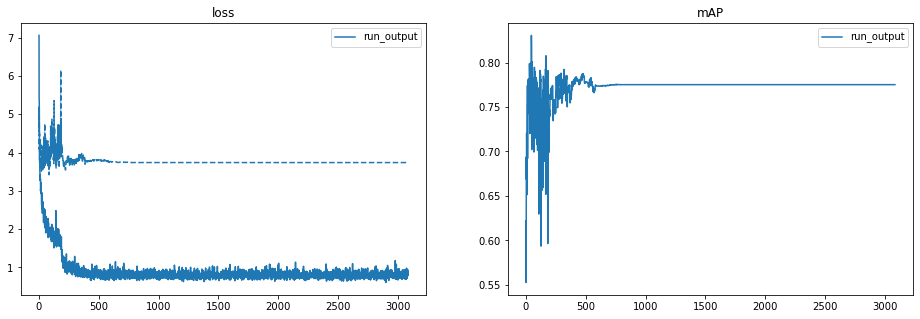

In [154]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

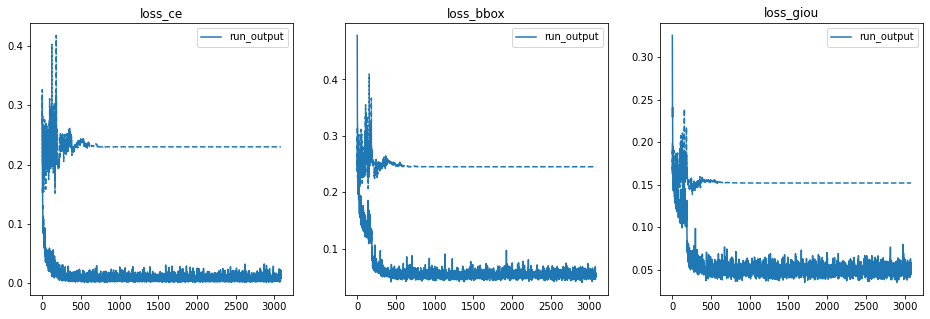

In [155]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

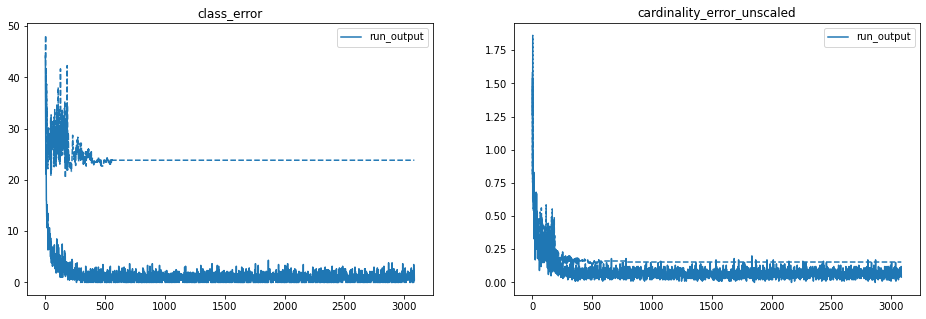

In [156]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [59]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('old_run_output/2020-09-08_contd_gen_big_5000_eval_100_real_68%mAP/checkpoint.pth', map_location='cpu')

model.load_state_dict(checkpoint['model'], strict=False)

model.eval();

Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_detr_master


### Boilerplate functions to display fine-tuned results

In [60]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [61]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,0.5)


  plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


  #for threshold in [0.9, 0.7]:
    
  #  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
  #                                                            threshold=threshold)

  #  print(probas_to_keep)

   # plot_finetuned_results(my_image,
                          #  probas_to_keep, 
                          #  bboxes_scaled)


### With a training image

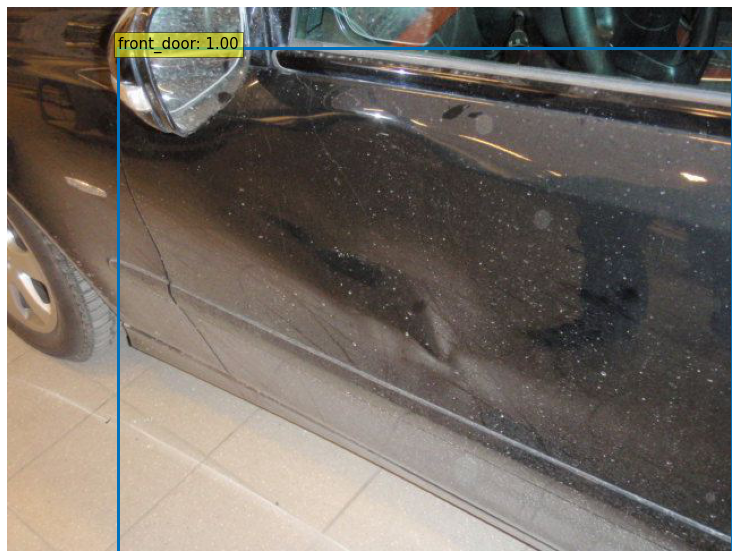

In [152]:
from PIL import Image

img_name = '/mnt/data2/datasets/detr_doors-2020-09-08/val2017/015.jpg'
im = Image.open(img_name)

run_worflow(im, model)

### With a validation image

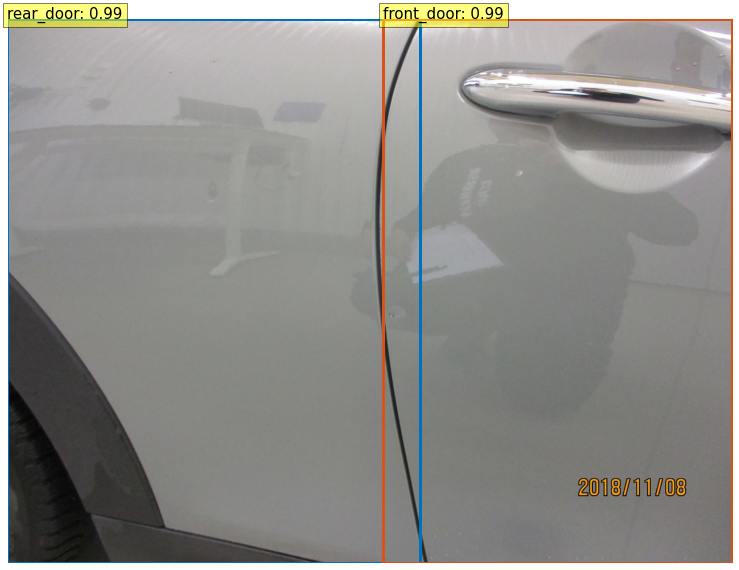

In [256]:
from PIL import Image

img_name = '/mnt/data2/datasets/detr_doors_coco_structure_100_images/val2017/026.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)